# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'its', 'ma', 've', 'wasn', 'off', 'yours', 'any', 'haven', 'has', 'there', "couldn't", 'her', 'their', 'did', 'up', 'which', 'between', "doesn't", 'y', 'until', "you've", 'should', 'now', 'under', 'ourselves', 'such', 'this', 'by', 'over', 'further', "shouldn't", "aren't", 'with', 'themselves', 'where', 'o', 'very', 'above', 'below', 'before', "mustn't", 'and', 'after', "wouldn't", 'in', "she's", 'at', 'own', 'mightn', 'doing', 'they', 'if', 'be', 'not', 'd', 'll', "wasn't", 'himself', "shan't", 'what', 'having', 'nor', 'yourselves', 'no', 'into', 'few', "you'll", 'some', 'she', 'whom', 'do', 'didn', 'doesn', 'me', 'who', 'once', 'both', 'those', 'the', 'been', "hadn't", 'are', 'am', 'from', 'have', 'against', 'only', 'as', 'yourself', 'them', 'because', 'so', "you'd", "should've", 'my', 'he', 'is', 'hadn', 'were', 'during', 'for', 'or', 'hers', 'than', 'same', 'hasn', 'ours', 'does', 'each', 'aren', 'all', 'isn', "you're", 'about', "needn't", 'i', 're', 'ain', 'myself', 'on', "weren'

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [15]:
random_final = final.sample(n=10000) # Sampling 10k rows 
print(random_final.shape)

(10000, 11)


In [16]:
random_final = random_final.sort_values('Time') # Sorting the dataframe based on Time

In [17]:
random_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...
226060,245108,B001O8NLV2,A356HBGSVZ5NRH,"B.P. ""tilley_traveler""",14,14,positive,1038009600,Perpetually Delicious - Tazo Makes The Best!,"For me, when the days get colder nothing is as...",day get colder noth reward simpl cup hot tea c...
298759,323603,B0000CNU5A,A2WNWOJDL0A81,Jonathan Sprenke,1,2,positive,1065398400,mmmmmm salty,This product reminds me of a thousand lunches ...,product remind thousand lunch chicken teriyaki...
62127,67497,B0000D9N7U,AQFIH82DRPMW,Patrick O'Brien,26,26,positive,1068940800,Try It!,"If you've never had real Swiss fondue, you're ...",youv never real swiss fondu your realli miss s...
428912,463849,B0000SXEKA,A2801SG8XA9LNX,PACW,7,8,negative,1069113600,Ohhh ick!,"This frosting is sweet, and it is low in calor...",frost sweet low calori whenev come across term...
86599,94282,B0000CNU2Q,A1IU7S4HCK1XK0,Joanna Daneman,14,14,positive,1072656000,"Essential for Tonkatsu, etc",This is the Japanese version of breadcrumb (pa...,japanes version breadcrumb portugues panko use...
516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,positive,1072915200,The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
146675,159109,B000GG1UIE,A28SJYEFR84MU1,L Flores,0,0,positive,1075680000,My Favorite Tea,I love Sleepytime Tea! I've been drinking it ...,love sleepytim tea ive drink year sooth bed ta...
134768,146281,B0000DID5R,A3TC2KE8OIKXMI,J. Miele,29,31,positive,1078099200,Use with caution,"Ok folks, this is not a joke. I am a real fan...",folk joke real fan hot sauc hot pepper anyth m...
158877,172255,B0000C69FP,A2DEQIN34WWO9I,"Anton Pavlovich ""chekhov""",0,0,positive,1082073600,Sometimes 5 stars aren't enough.,Such is the case with this tea. This mellow y...,case tea mellow yet flavor pleasant tea perfec...


# Avg. W2V

In [18]:
y_w2v = random_final['Score']
random_final.drop(['Score'], axis=1, inplace=True)
X_w2v = random_final

In [42]:
X_w2v.shape
y_w2v.value_counts()

positive    8413
negative    1587
Name: Score, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

# split the data set into train and test in 70% train and 30% test
X3, X_test3, y3, y_test3 = train_test_split(X_w2v, y_w2v, test_size=0.3, shuffle=False, random_state=42)

In [21]:
# Training Word2Vec using our corpus on Train data 
import gensim
i=0
list_of_sent=[]
for sent in X3['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [22]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=6)


In [23]:
# Applying average word2vec on test data
import gensim
i=0
list_of_sent1=[]
for sent in X_test3['Text'].values:
    filtered_sentence1=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence1.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent1.append(filtered_sentence1)

In [24]:
w2v_model1=gensim.models.Word2Vec(list_of_sent1,min_count=5,size=50, workers=6)


In [25]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent1: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    cnt_words1 =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            sent_vec1 += vec
            cnt_words1 += 1
        except:
            pass
    sent_vec1 /= cnt_words1
    sent_vectors1.append(sent_vec1)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

3000
50


In [27]:
df_w2v = pd.DataFrame(sent_vectors) # storing average w2vec in a dataframe


In [28]:
df_w2v1 = pd.DataFrame(sent_vectors1)


In [29]:
df_w2v.isnull().any() # Check whether if there is any Nan value


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [30]:
df_w2v1.isnull().any()


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [50]:
# Oversampling for Decision Tree

#from unbalanced_dataset import SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', random_state=42, kind='borderline1',  n_jobs=-1) # using the borderline1 algo for resampling on minority class
X5, y5 = sm.fit_sample(df_w2v, y3)


In [51]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v = StandardScaler().fit_transform(X5)
print(standardized_data_av_w2v.shape)

(11846, 50)


In [52]:
X_av_w2v_tr = np.array(standardized_data_av_w2v)

In [53]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v1 = StandardScaler().fit_transform(df_w2v1)
print(standardized_data_av_w2v1.shape)

(3000, 50)


In [54]:
X_av_w2v_te = np.array(standardized_data_av_w2v1)


 optimal depth is 12.


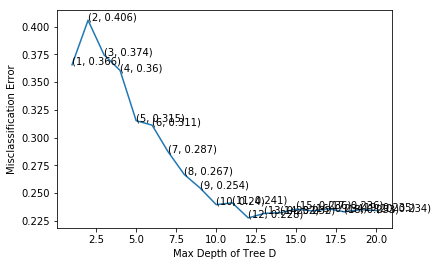

the misclassification error for each depth value is :  [0.366 0.406 0.374 0.36  0.315 0.311 0.287 0.267 0.254 0.24  0.241 0.228
 0.232 0.232 0.236 0.234 0.236 0.233 0.235 0.234]


In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit

# creating depth for decision tree
Depth = list(range(1,21))

# empty list holding CV scores
cv_scores = []

tss_dc = TimeSeriesSplit(n_splits = 10)

for d in Depth:
    dtc = DecisionTreeClassifier(max_depth = d, random_state = 42, presort = True)   # as data is sampled and not large so presorting it
    
    scores = cross_val_score(dtc, X_av_w2v_tr, y5, cv = tss_dc)
    cv_scores.append(scores.mean())
    
# changing to missclassification error
MSE = [1 - x for x in cv_scores]

# determining best depth

best_d = Depth[MSE.index(min(MSE))]
print('\n optimal depth is %d.' % best_d)


# plot missclassification error vs depth

plt.plot(Depth, MSE)

for xy in zip(Depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Max Depth of Tree D')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MSE,3))

In [61]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score, precision_score

# instantiate learning model for best depth

dt_w2v_op = DecisionTreeClassifier(max_depth = 14, random_state = 42, presort = True)

# fitting the model
dt_w2v_op.fit(X_av_w2v_tr, y5)

# predict the response
pred_dt_w2v_op = dt_w2v_op.predict(X_av_w2v_te)


# evaluate various performance measures:
print("Accuracy = ",accuracy_score(y_test3, pred_dt_w2v_op)) # accuracy
print("Confusion Matrix\n", confusion_matrix(y_test3, pred_dt_w2v_op)) # Confusion Matrix
tn, fn, fp, tp = confusion_matrix(y_test3, pred_dt_w2v_op).ravel() # tn, fn, fp, tp
print("(tn, fn, fp, tp) =",(tn, fn, fp, tp))
print("Recall = ",recall_score(y_test3, pred_dt_w2v_op, pos_label='positive')) # Recall
print("f1-Score = "  ,f1_score(y_test3, pred_dt_w2v_op, pos_label='positive')) # f1-Score
print("Precision = ",precision_score(y_test3, pred_dt_w2v_op, pos_label='positive'))# Precision

Accuracy =  0.5676666666666667
Confusion Matrix
 [[ 252  258]
 [1039 1451]]
(tn, fn, fp, tp) = (252, 258, 1039, 1451)
Recall =  0.5827309236947791
f1-Score =  0.6911169326030007
Precision =  0.8490345231129316


# TFIDF-W2V

In [62]:
from sklearn.model_selection import train_test_split

# split the data set into train and test in 70% train and 30% test
X4, X_test4, y4, y_test4 = train_test_split(X_w2v, y_w2v, test_size=0.3, shuffle=False, random_state=42)

In [63]:
# Taking Tf-idf unigram and vectorizing it
tf_idf_vect = TfidfVectorizer()
X_tf = tf_idf_vect.fit_transform(X4['CleanedText'].values)
y_tf = tf_idf_vect.fit_transform(X_test4['CleanedText'].values)

In [77]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X4['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

7000
50


In [78]:
df_w2v_tf = pd.DataFrame(tfidf_sent_vectors) # storing average w2vec in a dataframe

In [79]:
df_w2v_tf.isnull().any() # Check whether if there is any Nan value

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
dtype: bool

In [80]:
df_w2v_tf = df_w2v_tf.fillna(0) #filling the dataframe with 0 if there is any Nan entry


In [81]:
# Oversampling of train data in order to make the minority class balanced with majority class

from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', random_state=42, kind='borderline1',  n_jobs=-1) # using the borderline1 algo for resampling on minority class
X6, y6 = sm.fit_sample(df_w2v_tf, y4)

In [82]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_tf_tr = StandardScaler().fit_transform(X6)
print(standardized_data_av_w2v_tf_tr.shape)

(11846, 50)


In [89]:
X_w2v_tf_tr = np.array(standardized_data_av_w2v_tf_tr)

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_test4['Text'].values: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec1 += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec1 /= weight_sum
    tfidf_sent_vectors1.append(sent_vec1)
    row += 1
    
print(len(tfidf_sent_vectors1))
print(len(tfidf_sent_vectors1[0]))

3000
50


In [91]:
df_w2v_tf_1 = pd.DataFrame(tfidf_sent_vectors1) # storing average w2vec in a dataframe

In [92]:
df_w2v_tf_1 = df_w2v_tf_1.fillna(0) #filling the dataframe with 0 if there is any Nan entry

In [93]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_tf_te = StandardScaler().fit_transform(df_w2v_tf_1)
print(standardized_data_av_w2v_tf_te.shape)

(3000, 50)


In [94]:
X_w2v_tf_te = np.array(standardized_data_av_w2v_tf_te)


The optimal depth is 1.


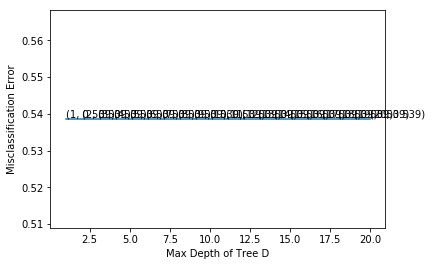

the misclassification error for each depth value is :  [0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539
 0.539 0.539 0.539 0.539 0.539 0.539 0.539 0.539]


In [95]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
                            
    
# creating depth for Decision Tree
myDepth_tf = list(range(1,21))

# empty list that will hold cv scores
cv_scores_t = []

tss_d_tf = TimeSeriesSplit(n_splits=10) # split the data using TimeSeriesSplit with number of splits=10

# perform 10-fold cross validation 
for d in myDepth_tf:
    dtc_tf = DecisionTreeClassifier(max_depth = d, random_state = 0, presort = True) # as the data is sampled and not large so pre-sorting it
    scores_t = cross_val_score(dtc_tf, X_w2v_tf_tr, y6, cv=tss_d_tf)
    cv_scores_t.append(scores_t.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores_t]

# determining best depth
best_dtf = myDepth_tf[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % best_dtf)

# plot misclassification error vs depth 
plt.plot(myDepth_tf, MSE)

for xy in zip(myDepth_tf, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Max Depth of Tree D')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MSE,3))

In [96]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score, precision_score


# instantiate learning model for best depth
dt_w2v_op_tf = DecisionTreeClassifier(max_depth = 1, random_state = 42, presort = True)

# fitting the model
dt_w2v_op_tf.fit(X_w2v_tf_tr, y6)

# predict the response
pred_dt_w2v_op_tf = dt_w2v_op_tf.predict(X_w2v_tf_te)

print()

# evaluate various performance measures:
print("Accuracy = ",accuracy_score(y_test4, pred_dt_w2v_op_tf)) # accuracy
print("Confusion Matrix\n", confusion_matrix(y_test4, pred_dt_w2v_op_tf)) # Confusion Matrix
tn, fn, fp, tp = confusion_matrix(y_test4, pred_dt_w2v_op_tf).ravel() # tn, fn, fp, tp
print("(tn, fn, fp, tp) =",(tn, fn, fp, tp))
print("Recall = ",recall_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive')) # Recall
print("f1-Score = "  ,f1_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive')) # f1-Score
print("Precision = ",precision_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive'))# Precision


Accuracy =  0.17
Confusion Matrix
 [[ 510    0]
 [2490    0]]
(tn, fn, fp, tp) = (510, 0, 2490, 0)
Recall =  0.0
f1-Score =  0.0
Precision =  0.0


Observations : The optimal depth is higher for avg. w2v (12) compared to tf-idf weighted w2v(1) while missclassification error is higher for tfidf-weighted w2v(0.539) compared to avg w2v(0.232)